# HW7

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import scipy.io
from mpl_toolkits.mplot3d import Axes3D

## 1 (Multidimensional scaling)

In [55]:
data = scipy.io.loadmat("./SubjSim12Countries.mat") 
S = data['S']
print(S.shape)
country_names = list(data['cname'])
print(country_names)

(12, 12)
['Bra', 'Con', 'Cub', 'Egy', 'Fra', 'Ind', 'Isr', 'Jap', 'Chi', 'Rus', 'USA', 'Yug']


In [56]:
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        if i != j:
            # convering to (9 - S values)**2 so that 1 in the original matrix (very different) is 9
            # and 9 (very similar) is 1
            S[i,j] = (9 - S[i,j])**2

Text(15,0,'Pro-Communist')

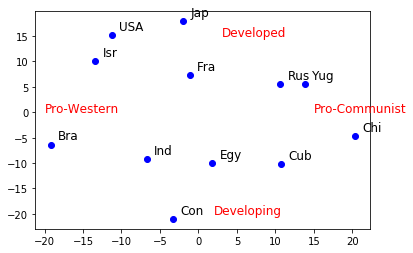

In [60]:
from sklearn.manifold import MDS

# using MDS routine from scikit-learn
model = MDS(n_components=2,dissimilarity='precomputed',random_state=1) 
out = model.fit_transform(S)
plt.scatter(out[:,0],out[:,1],c='b')

for i,name in enumerate(country_names):
    plt.annotate(name,(out[i,0]+1,out[i,1]+1),fontsize=12)

plt.annotate("Developing",(2,-20),color="red",fontsize=12)
plt.annotate("Developed",(3,15),color="red",fontsize=12)
plt.annotate("Pro-Western",(-20,0),color="red",fontsize=12)
plt.annotate("Pro-Communist",(15,0),color="red",fontsize=12)

#plt.ylim([-30,30])

# 2 (Diffusion Map)

In [92]:
def make_spiral(N=100,sigma=0.02):
    '''
        N = number of points
        sigma =  noise level
    '''
    t = np.linspace(0,2*np.pi,N)
    z = np.cos(t)
    r = 1 - 0.5*np.sin(t)
    phi = 10*t
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    
    X = np.array([x,y,z]) + sigma*np.random.randn(3,N)
    return X.T

Text(0.5,0.92,'Points of the helix in 3D')

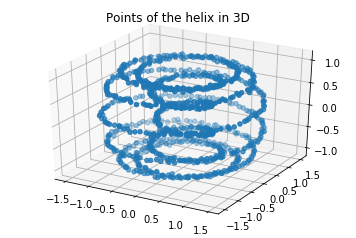

In [155]:
N = 1000
sigma = 0.02
X = make_spiral(N,sigma)

fig = plt.figure()
ax = fig.add_subplot('111',projection='3d')

ax.scatter(X[:,0],X[:,1],X[:,2])
ax.set_title("Points of the helix in 3D")

Text(0.5,1,'Density')

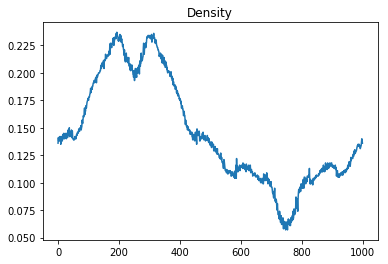

In [118]:
# compute pairwise distances
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)**2

rad = 1
q = np.zeros(N)
for i in range(N):
    q[i] = len(np.where(D[:,i] < rad**2)[0])
#normalize density
q = q/N
plt.plot(q)
plt.title("Density")

In [95]:
# diffusion map algorithm, takes in pariwise distances, returns diffusion map co-ordinates

def kernel(Delta,eps):
    return np.exp(-Delta/eps)

def calc_diffusion_map(D,q,eps,alpha):
    '''
        D : matrix of pairwise distance sqaured
        eps : epsilon parameter for the kernel
        alpha : controls the sensitivity to data density
    '''
    K = kernel(D,eps)
    K = K/np.sum(K)
    new_K = K/(np.power(q,alpha)[:,np.newaxis] * np.power(q,alpha))
    d = np.sum(new_K,axis=1)
    
    # calculating P 
    P = np.diag(1/d) @ new_K
    
    A = np.sqrt(np.diag(d)) @ P @ np.sqrt(np.diag(1/d))
    w,v = np.linalg.eigh(A)
    
    lambda_vec = w
    r_mat = np.sqrt(np.diag(1/d))@v
    return lambda_vec,r_mat

N=1000,sigma=0.020
epsilon = 0.020


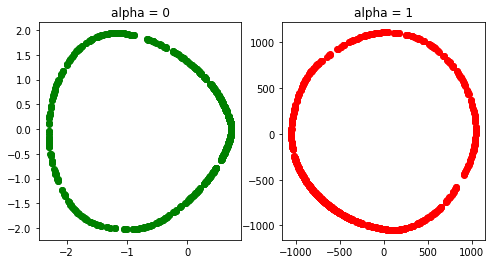

<Figure size 432x288 with 0 Axes>

In [154]:
N = 1000
sigma = 0.02
X = make_spiral(N,sigma)
D = pairwise_distances(X)

rad = 0.5
q = np.zeros(N)
for i in range(N):
    q[i] = len(np.where(D[:,i] < rad**2)[0])
#normalize density
q = q/N
eps = 2e-2
lambda_vec,r_mat = calc_diffusion_map(D,q,eps=eps,alpha=0)
t = 10
f,ax = plt.subplots(1,2,figsize=(8,4))
psi_0 = np.power(lambda_vec[-2],t)*r_mat[:,-2]
psi_1 = np.power(lambda_vec[-3],t)*r_mat[:,-3]
ax[0].scatter(psi_0,psi_1,c='g')
ax[0].set_title("alpha = 0")

lambda_vec,r_mat = calc_diffusion_map(D,q,eps=eps,alpha=1)
t = 10
plt.figure()
psi_0 = 1e5*np.power(lambda_vec[-2],t)*r_mat[:,-2]
psi_1 = 1e5*np.power(lambda_vec[-3],t)*r_mat[:,-3]
ax[1].scatter(psi_0,psi_1,c='r')
ax[1].set_title("alpha = 1")

print("N={:d},sigma={:.3f}".format(N,sigma))
print("epsilon = {:.3f}".format(eps))

The algorithm break if N is too small (< 150) for sigma = 0.01, or if noise level sigma is larger than eps. (see output below)

Low number of points
N=150,sigma=0.010
epsilon = 0.020


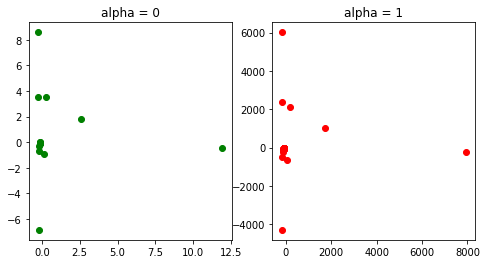

<Figure size 432x288 with 0 Axes>

High noise level as compared to epsilon
N=500,sigma=0.050
epsilon = 0.020


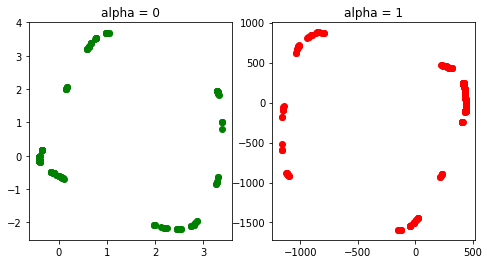

<Figure size 432x288 with 0 Axes>

In [153]:
N = 150
sigma = 0.01
X = make_spiral(N,sigma)
D = pairwise_distances(X)

rad = 0.5
q = np.zeros(N)
for i in range(N):
    q[i] = len(np.where(D[:,i] < rad**2)[0])
#normalize density
q = q/N

eps = 2e-2
lambda_vec,r_mat = calc_diffusion_map(D,q,eps=eps,alpha=0)
t = 10
f,ax = plt.subplots(1,2,figsize=(8,4))
psi_0 = np.power(lambda_vec[-2],t)*r_mat[:,-2]
psi_1 = np.power(lambda_vec[-3],t)*r_mat[:,-3]
ax[0].scatter(psi_0,psi_1,c='g')
ax[0].set_title("alpha = 0")

lambda_vec,r_mat = calc_diffusion_map(D,q,eps=eps,alpha=1)
t = 10
plt.figure()
psi_0 = 1e5*np.power(lambda_vec[-2],t)*r_mat[:,-2]
psi_1 = 1e5*np.power(lambda_vec[-3],t)*r_mat[:,-3]
ax[1].scatter(psi_0,psi_1,c='r')
ax[1].set_title("alpha = 1")

print("Low number of points")
print("N={:d},sigma={:.3f}".format(N,sigma))
print("epsilon = {:.3f}".format(eps))

plt.show()
N = 500
sigma = 0.05
X = make_spiral(N,sigma)
D = pairwise_distances(X)

rad = 0.5
q = np.zeros(N)
for i in range(N):
    q[i] = len(np.where(D[:,i] < rad**2)[0])
#normalize density
q = q/N

eps = 2e-2
lambda_vec,r_mat = calc_diffusion_map(D,q,eps=eps,alpha=0)
t = 10
f,ax = plt.subplots(1,2,figsize=(8,4))
psi_0 = np.power(lambda_vec[-2],t)*r_mat[:,-2]
psi_1 = np.power(lambda_vec[-3],t)*r_mat[:,-3]
ax[0].scatter(psi_0,psi_1,c='g')
ax[0].set_title("alpha = 0")

lambda_vec,r_mat = calc_diffusion_map(D,q,eps=eps,alpha=1)
t = 10
plt.figure()
psi_0 = 1e5*np.power(lambda_vec[-2],t)*r_mat[:,-2]
psi_1 = 1e5*np.power(lambda_vec[-3],t)*r_mat[:,-3]
ax[1].scatter(psi_0,psi_1,c='r')
ax[1].set_title("alpha = 1")

print("High noise level as compared to epsilon")
print("N={:d},sigma={:.3f}".format(N,sigma))
print("epsilon = {:.3f}".format(eps))

# 4 (Filtering)

In [1]:
import scipy.integrate

def dv_dt(v,t):
    mu = 0.119
    nu = 0.1
    G = 0.9
    der = np.zeros(len(v))
    der[0] = mu*v[0] - v[1]*v[2]
    der[1] = -nu*v[1] + v[0]*v[2]
    der[2] = G - v[2] + v[0]*v[1]
    return der


def Psi(v_0):
    t_vec = np.linspace(0,3,100)
    res = scipy.integrate.odeint(dv_dt,v_0,t_vec)
    return res[-1]

def model(v_n,sigma):
    return Psi(v_n) + sigma*np.random.randn(3)

def obs(v_n,gamma):
    h_vec = np.array([0,1,0])
    return np.sum(h_vec*v_n) + gamma*np.random.randn(1)

## EnKF

In [72]:
# Ensenbele Kalman filter
# number of time steps
J = 1000
# number of ensemble members
N = 50


m_vec = np.zeros((J,3))
C_vec = np.zeros((J,3,3))

m_vec[0] = np.array([0,0,0])
C_vec[0] = np.eye(3)

sigma = 0.1
Sigma = sigma*np.eye(3)
gamma = 0.3
Gamma = gamma*np.eye(1)

v_vec = np.zeros((J,3))
y_vec = np.zeros((J,1))
v_vec[0] = m_vec[0]
for i in range(1,J):
    v_vec[i] = model(v_vec[i-1],sigma)
    y_vec[i] = obs(v_vec[i],gamma)

# obs matrix
H = np.array([0,1,0]) 
# initialization
U_vec = np.zeros((3,N))
for i in range(N):
    U_vec[:,i] = m_vec[0] + scipy.linalg.sqrtm(C_vec[0]) @ np.random.randn(3)

# main body
for j in range(1,J):
    # prediction step
    Uhat_vec = np.zeros(U_vec.shape)
    for k in range(N):
        Uhat_vec[:,k] = Psi(U_vec[:,k]) + scipy.linalg.sqrtm(Sigma) @ np.random.randn(3)
    mhat = np.mean(Uhat_vec,axis=1)
    Chat = np.cov(Uhat_vec)
    
    #analysis step
    d = y_vec[j] + scipy.linalg.sqrtm(Gamma) @ np.random.randn(1,N) - H @ Uhat_vec
    K = Chat @ H[np.newaxis].T @ np.linalg.inv(Gamma + H @ Chat @ H.T)
    U_vec = Uhat_vec + K @ d
    m_vec[j] = np.mean(U_vec,axis=1)
    C_vec[j] = np.cov(U_vec)

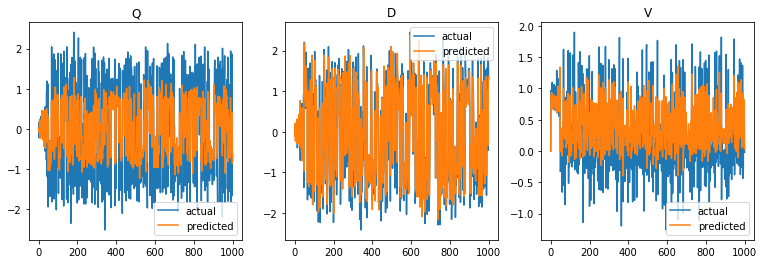

In [73]:
f,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].plot(v_vec[:,0],label="actual")
ax[0].plot(m_vec[:,0],label="predicted")
ax[0].set_title("Q")
ax[0].legend()
ax[1].plot(v_vec[:,1],label="actual")
ax[1].plot(m_vec[:,1],label="predicted")
ax[1].set_title("D")
ax[1].legend()
ax[2].plot(v_vec[:,2],label="actual")
ax[2].plot(m_vec[:,2],label="predicted")
ax[2].set_title("V")
ax[2].legend()


Text(0.5,1,'Actual and observed second component')

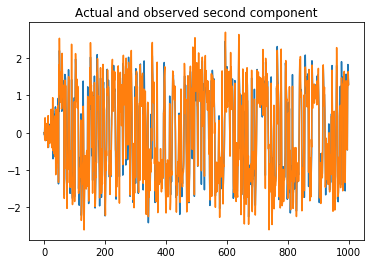

In [74]:
plt.plot(v_vec[:,1],label="actual")
plt.plot(y_vec[:],label="observation")
plt.title("Actual and observed second component")

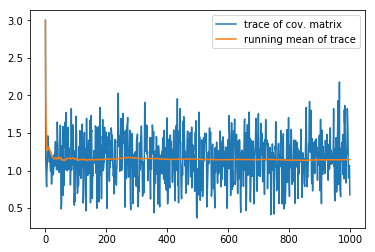

In [75]:
trace_vec = np.trace(C_vec.T)
plt.plot(trace_vec,label="trace of cov. matrix")
trace_running_avg_vec = np.cumsum(trace_vec)/np.arange(1,trace_vec.shape[0]+1)
plt.plot(trace_running_avg_vec,label="running mean of trace")
plt.legend()

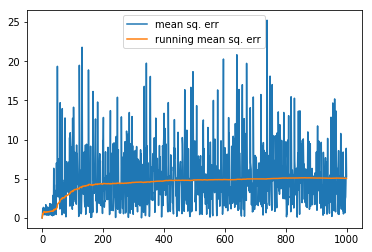

In [76]:
err_vec = np.linalg.norm(y_vec-m_vec,axis=1)**2
plt.plot(err_vec,label="mean sq. err")
err_running_avg_vec = np.cumsum(err_vec)/np.arange(1,err_vec.shape[0]+1)
plt.plot(err_running_avg_vec,label="running mean sq. err")
plt.legend()

## Ensemble Transform Kalman filter

In [77]:
# Ensenbele Kalman filter
# number of time steps
J = 1000
# number of ensemble members
N = 50


m_vec = np.zeros((J,3))
C_vec = np.zeros((J,3,3))

m_vec[0] = np.array([0,0,0])
C_vec[0] = np.eye(3)

sigma = 0.1
Sigma = sigma*np.eye(3)
gamma = 0.3
Gamma = gamma*np.eye(1)

v_vec = np.zeros((J,3))
y_vec = np.zeros((J,1))
v_vec[0] = m_vec[0]
for i in range(1,J):
    v_vec[i] = model(v_vec[i-1],sigma)
    y_vec[i] = obs(v_vec[i],gamma)

# obs matrix
H = np.array([0,1,0]) 
# initialization
U_vec = np.zeros((3,N))
for i in range(N):
    U_vec[:,i] = m_vec[0] + scipy.linalg.sqrtm(C_vec[0]) @ np.random.randn(3)

# main body
for j in range(1,J):
    # prediction step
    Uhat_vec = np.zeros(U_vec.shape)
    for k in range(N):
        Uhat_vec[:,k] = Psi(U_vec[:,k]) + scipy.linalg.sqrtm(Sigma) @ np.random.randn(3)
    mhat = np.mean(Uhat_vec,axis=1)
    Xhat = (1/np.sqrt(N-1))*(Uhat_vec - mhat[np.newaxis].T)
    Chat = Xhat @ Xhat.T
    
    #analysis step
    T = np.linalg.inv(scipy.linalg.sqrtm(np.eye(1) + H @ Chat @ H.T))
    X = Xhat * T
    d = y_vec[j] - H @ mhat
    K = Chat @ H[np.newaxis].T @ np.linalg.inv(Gamma + H @ Chat @ H.T)
    m_vec[j] = mhat + K @ d
    U_vec = m_vec[j][np.newaxis].T + np.sqrt(N-1) * X
    C_vec[j] = X @ X.T

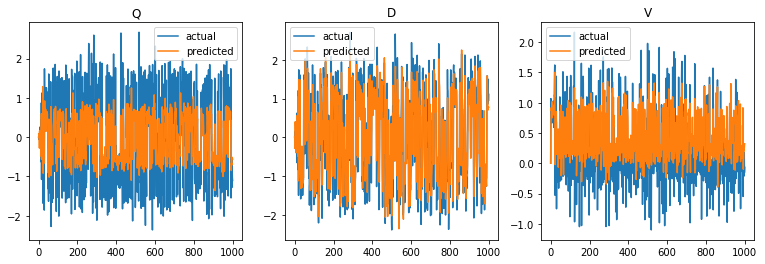

In [78]:
f,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].plot(v_vec[:,0],label="actual")
ax[0].plot(m_vec[:,0],label="predicted")
ax[0].set_title("Q")
ax[0].legend()
ax[1].plot(v_vec[:,1],label="actual")
ax[1].plot(m_vec[:,1],label="predicted")
ax[1].set_title("D")
ax[1].legend()
ax[2].plot(v_vec[:,2],label="actual")
ax[2].plot(m_vec[:,2],label="predicted")
ax[2].set_title("V")
ax[2].legend()

Text(0.5,1,'Actual and observed second component')

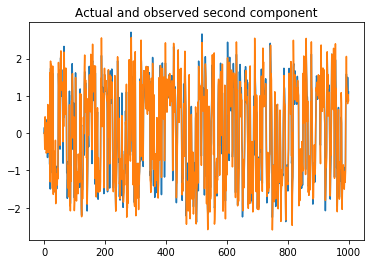

In [79]:
plt.plot(v_vec[:,1],label="actual")
plt.plot(y_vec[:],label="observation")
plt.title("Actual and observed second component")

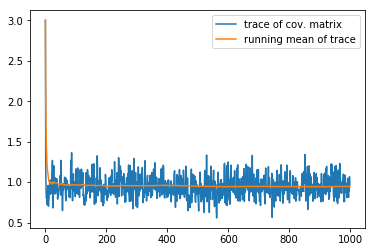

In [80]:
trace_vec = np.trace(C_vec.T)
plt.plot(trace_vec,label="trace of cov. matrix")
trace_running_avg_vec = np.cumsum(trace_vec)/np.arange(1,trace_vec.shape[0]+1)
plt.plot(trace_running_avg_vec,label="running mean of trace")
plt.legend()

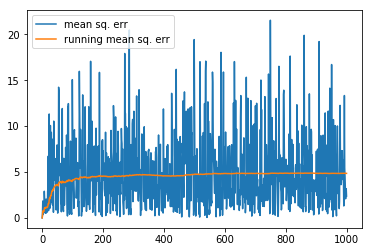

In [81]:
err_vec = np.linalg.norm(y_vec-m_vec,axis=1)**2
plt.plot(err_vec,label="mean sq. err")
err_running_avg_vec = np.cumsum(err_vec)/np.arange(1,err_vec.shape[0]+1)
plt.plot(err_running_avg_vec,label="running mean sq. err")
plt.legend()

## Particle Filter

In [82]:
# Particle filter
# number of time steps
J = 1000
# number of ensemble members
N = 50


m_vec = np.zeros((J,3))
C_vec = np.zeros((J,3,3))

m_vec[0] = np.array([0,0,0])
C_vec[0] = np.eye(3)

sigma = 0.1
Sigma = sigma*np.eye(3)
gamma = 0.3
Gamma = gamma*np.eye(1)

v_vec = np.zeros((J,3))
y_vec = np.zeros((J,1))
v_vec[0] = m_vec[0]
for i in range(1,J):
    v_vec[i] = model(v_vec[i-1],sigma)
    y_vec[i] = obs(v_vec[i],gamma)

# obs matrix
H = np.array([0,1,0]) 
# initialization
U_vec = np.zeros((3,N))
for i in range(N):
    U_vec[:,i] = m_vec[0] + scipy.linalg.sqrtm(C_vec[0]) @ np.random.randn(3)

# main body
for j in range(1,J):
    # prediction step
    Uhat_vec = np.zeros(U_vec.shape)
    for k in range(N):
        Uhat_vec[:,k] = Psi(U_vec[:,k]) + scipy.linalg.sqrtm(Sigma) @ np.random.randn(3)
    d = y_vec[j] - H @ Uhat_vec
    what = np.exp(-0.5*d * np.linalg.inv(Gamma) * d[np.newaxis])
    what = what/np.sum(what)
    ws = np.cumsum(what)
    # resampling
    for i in range(N):
        rand = np.random.uniform()
        ix = np.where(ws > rand)[0][0]
        U_vec[:,i] = Uhat_vec[:,ix]
    m_vec[j] = np.mean(U_vec,axis=1)
    C_vec[j] = np.cov(U_vec)

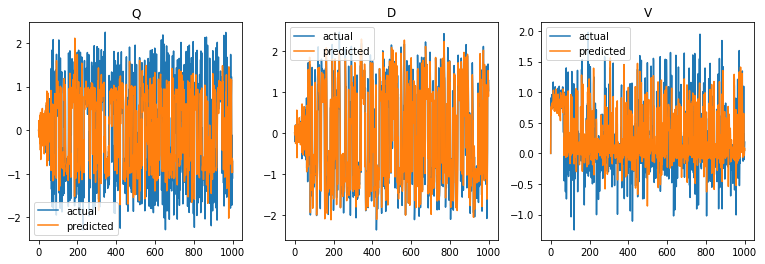

In [83]:
f,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].plot(v_vec[:,0],label="actual")
ax[0].plot(m_vec[:,0],label="predicted")
ax[0].set_title("Q")
ax[0].legend()
ax[1].plot(v_vec[:,1],label="actual")
ax[1].plot(m_vec[:,1],label="predicted")
ax[1].set_title("D")
ax[1].legend()
ax[2].plot(v_vec[:,2],label="actual")
ax[2].plot(m_vec[:,2],label="predicted")
ax[2].set_title("V")
ax[2].legend()

Text(0.5,1,'Actual and observed second component')

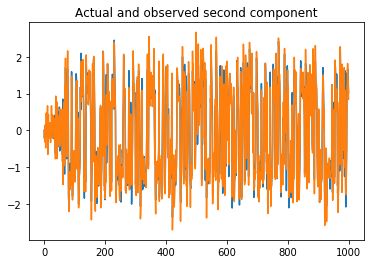

In [84]:
plt.plot(v_vec[:,1],label="actual")
plt.plot(y_vec[:],label="observation")
plt.title("Actual and observed second component")

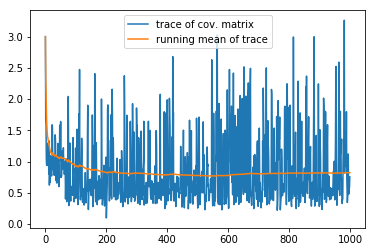

In [86]:
trace_vec = np.trace(C_vec.T)
plt.plot(trace_vec,label="trace of cov. matrix")
trace_running_avg_vec = np.cumsum(trace_vec)/np.arange(1,trace_vec.shape[0]+1)
plt.plot(trace_running_avg_vec,label="running mean of trace")
plt.legend()

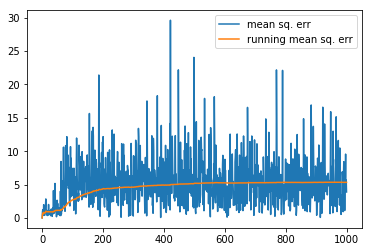

In [85]:
err_vec = np.linalg.norm(y_vec-m_vec,axis=1)**2
plt.plot(err_vec,label="mean sq. err")
err_running_avg_vec = np.cumsum(err_vec)/np.arange(1,err_vec.shape[0]+1)
plt.plot(err_running_avg_vec,label="running mean sq. err")
plt.legend()

### Performance 
- In terms of trace of Cov. matrix, the best performace is achived by the particle filter, followed by ETKF and EnKF.
- All three filters seem to perform equally well in the term of mean sq. error.
- The fastest convergence to the stable values in Cov. matrix trace and mean sq. error are achieved by the EnKF filter.

## (b)

### EnKF

sigma,gamma :  0 0.1
sigma,gamma :  0.1 0.1


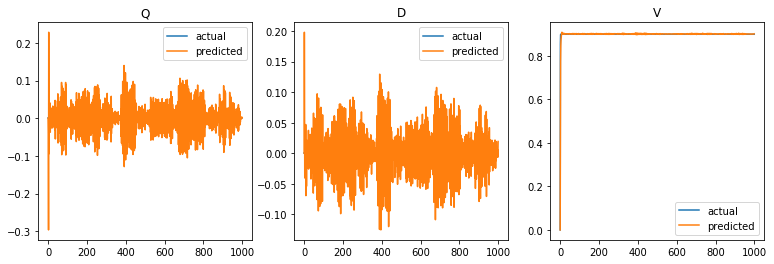

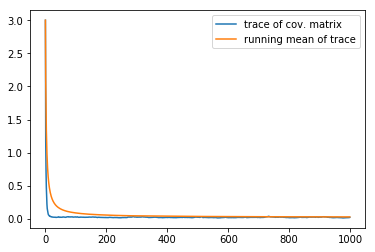

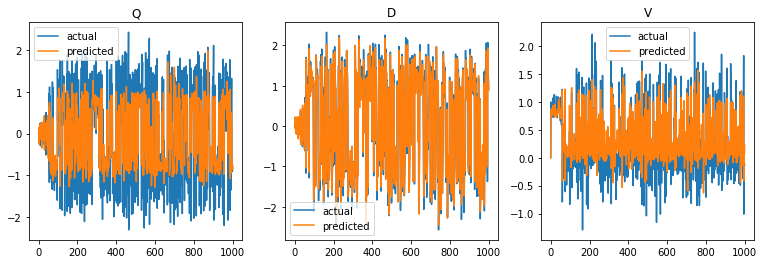

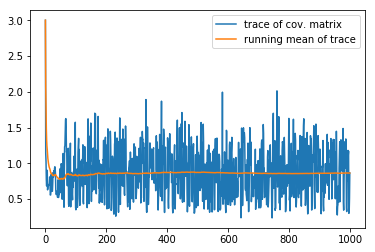

In [89]:
for (sigma,gamma) in [(0,0.1),(0.1,0.1)]:
    print("sigma,gamma : ",sigma,gamma)

    # Ensenbele Kalman filter
    # number of time steps
    J = 1000
    # number of ensemble members
    N = 50


    m_vec = np.zeros((J,3))
    C_vec = np.zeros((J,3,3))

    m_vec[0] = np.array([0,0,0])
    C_vec[0] = np.eye(3)

    Sigma = sigma*np.eye(3)
    Gamma = gamma*np.eye(1)

    v_vec = np.zeros((J,3))
    y_vec = np.zeros((J,1))
    v_vec[0] = m_vec[0]
    for i in range(1,J):
        v_vec[i] = model(v_vec[i-1],sigma)
        y_vec[i] = obs(v_vec[i],gamma)

    # obs matrix
    H = np.array([0,1,0]) 
    # initialization
    U_vec = np.zeros((3,N))
    for i in range(N):
        U_vec[:,i] = m_vec[0] + scipy.linalg.sqrtm(C_vec[0]) @ np.random.randn(3)

    # main body
    for j in range(1,J):
        # prediction step
        Uhat_vec = np.zeros(U_vec.shape)
        for k in range(N):
            Uhat_vec[:,k] = Psi(U_vec[:,k]) + scipy.linalg.sqrtm(Sigma) @ np.random.randn(3)
        mhat = np.mean(Uhat_vec,axis=1)
        Chat = np.cov(Uhat_vec)

        #analysis step
        d = y_vec[j] + scipy.linalg.sqrtm(Gamma) @ np.random.randn(1,N) - H @ Uhat_vec
        K = Chat @ H[np.newaxis].T @ np.linalg.inv(Gamma + H @ Chat @ H.T)
        U_vec = Uhat_vec + K @ d
        m_vec[j] = np.mean(U_vec,axis=1)
        C_vec[j] = np.cov(U_vec)
        
    f,ax = plt.subplots(1,3,figsize=(13,4))
    ax[0].plot(v_vec[:,0],label="actual")
    ax[0].plot(m_vec[:,0],label="predicted")
    ax[0].set_title("Q")
    ax[0].legend()
    ax[1].plot(v_vec[:,1],label="actual")
    ax[1].plot(m_vec[:,1],label="predicted")
    ax[1].set_title("D")
    ax[1].legend()
    ax[2].plot(v_vec[:,2],label="actual")
    ax[2].plot(m_vec[:,2],label="predicted")
    ax[2].set_title("V")
    ax[2].legend()
   
    plt.figure()
    trace_vec = np.trace(C_vec.T)
    plt.plot(trace_vec,label="trace of cov. matrix")
    trace_running_avg_vec = np.cumsum(trace_vec)/np.arange(1,trace_vec.shape[0]+1)
    plt.plot(trace_running_avg_vec,label="running mean of trace")
    plt.legend()

- EnKF works for both given values.

### ETKF

sigma,gamma :  0 0.1
sigma,gamma :  0.1 0.1


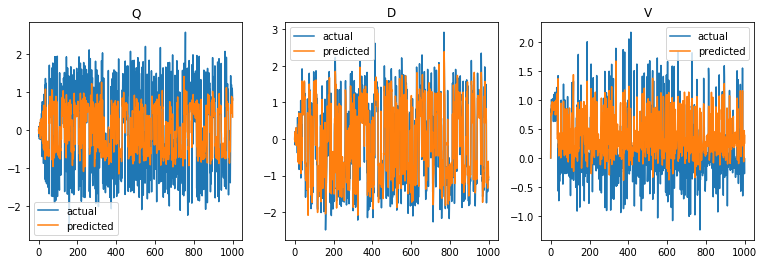

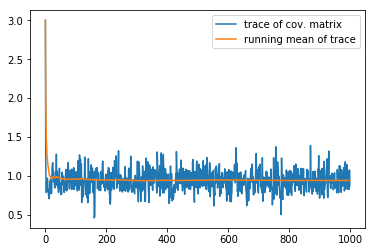

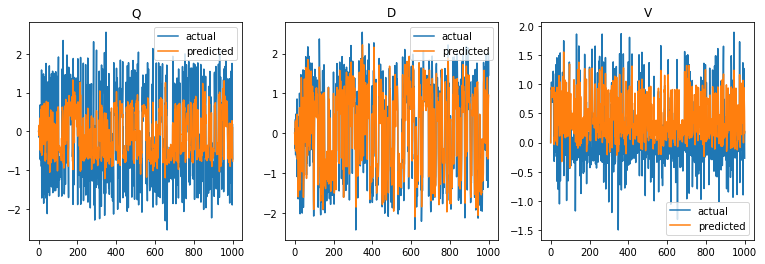

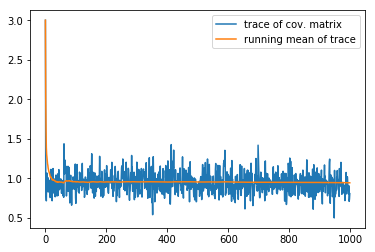

In [90]:
for (sigma,gamma) in [(0,0.1),(0.1,0.1)]:
    print("sigma,gamma : ",sigma,gamma)

    # number of time steps
    J = 1000
    # number of ensemble members
    N = 50


    m_vec = np.zeros((J,3))
    C_vec = np.zeros((J,3,3))

    m_vec[0] = np.array([0,0,0])
    C_vec[0] = np.eye(3)

    sigma = 0.1
    Sigma = sigma*np.eye(3)
    gamma = 0.3
    Gamma = gamma*np.eye(1)

    v_vec = np.zeros((J,3))
    y_vec = np.zeros((J,1))
    v_vec[0] = m_vec[0]
    for i in range(1,J):
        v_vec[i] = model(v_vec[i-1],sigma)
        y_vec[i] = obs(v_vec[i],gamma)

    # obs matrix
    H = np.array([0,1,0]) 
    # initialization
    U_vec = np.zeros((3,N))
    for i in range(N):
        U_vec[:,i] = m_vec[0] + scipy.linalg.sqrtm(C_vec[0]) @ np.random.randn(3)

    # main body
    for j in range(1,J):
        # prediction step
        Uhat_vec = np.zeros(U_vec.shape)
        for k in range(N):
            Uhat_vec[:,k] = Psi(U_vec[:,k]) + scipy.linalg.sqrtm(Sigma) @ np.random.randn(3)
        mhat = np.mean(Uhat_vec,axis=1)
        Xhat = (1/np.sqrt(N-1))*(Uhat_vec - mhat[np.newaxis].T)
        Chat = Xhat @ Xhat.T

        #analysis step
        T = np.linalg.inv(scipy.linalg.sqrtm(np.eye(1) + H @ Chat @ H.T))
        X = Xhat * T
        d = y_vec[j] - H @ mhat
        K = Chat @ H[np.newaxis].T @ np.linalg.inv(Gamma + H @ Chat @ H.T)
        m_vec[j] = mhat + K @ d
        U_vec = m_vec[j][np.newaxis].T + np.sqrt(N-1) * X
        C_vec[j] = X @ X.T  
        
    f,ax = plt.subplots(1,3,figsize=(13,4))
    ax[0].plot(v_vec[:,0],label="actual")
    ax[0].plot(m_vec[:,0],label="predicted")
    ax[0].set_title("Q")
    ax[0].legend()
    ax[1].plot(v_vec[:,1],label="actual")
    ax[1].plot(m_vec[:,1],label="predicted")
    ax[1].set_title("D")
    ax[1].legend()
    ax[2].plot(v_vec[:,2],label="actual")
    ax[2].plot(m_vec[:,2],label="predicted")
    ax[2].set_title("V")
    ax[2].legend()
   
    plt.figure()
    trace_vec = np.trace(C_vec.T)
    plt.plot(trace_vec,label="trace of cov. matrix")
    trace_running_avg_vec = np.cumsum(trace_vec)/np.arange(1,trace_vec.shape[0]+1)
    plt.plot(trace_running_avg_vec,label="running mean of trace")
    plt.legend()

- ETKF does not give exact results on sigma,gamma = (0,0.1) as compared to EnKF. 

### Particle Filter

sigma,gamma :  0 0.1
sigma,gamma :  0.1 0.1


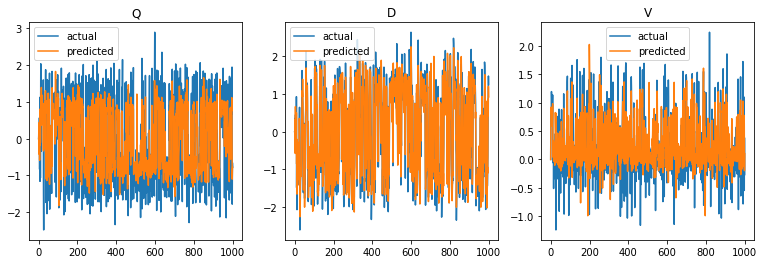

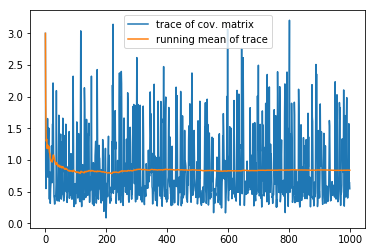

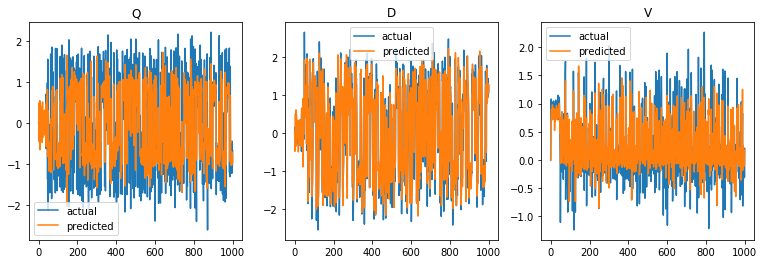

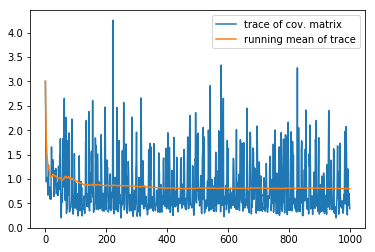

In [91]:
for (sigma,gamma) in [(0,0.1),(0.1,0.1)]:
    print("sigma,gamma : ",sigma,gamma)

   # Particle filter
    # number of time steps
    J = 1000
    # number of ensemble members
    N = 50


    m_vec = np.zeros((J,3))
    C_vec = np.zeros((J,3,3))

    m_vec[0] = np.array([0,0,0])
    C_vec[0] = np.eye(3)

    sigma = 0.1
    Sigma = sigma*np.eye(3)
    gamma = 0.3
    Gamma = gamma*np.eye(1)

    v_vec = np.zeros((J,3))
    y_vec = np.zeros((J,1))
    v_vec[0] = m_vec[0]
    for i in range(1,J):
        v_vec[i] = model(v_vec[i-1],sigma)
        y_vec[i] = obs(v_vec[i],gamma)

    # obs matrix
    H = np.array([0,1,0]) 
    # initialization
    U_vec = np.zeros((3,N))
    for i in range(N):
        U_vec[:,i] = m_vec[0] + scipy.linalg.sqrtm(C_vec[0]) @ np.random.randn(3)

    # main body
    for j in range(1,J):
        # prediction step
        Uhat_vec = np.zeros(U_vec.shape)
        for k in range(N):
            Uhat_vec[:,k] = Psi(U_vec[:,k]) + scipy.linalg.sqrtm(Sigma) @ np.random.randn(3)
        d = y_vec[j] - H @ Uhat_vec
        what = np.exp(-0.5*d * np.linalg.inv(Gamma) * d[np.newaxis])
        what = what/np.sum(what)
        ws = np.cumsum(what)
        # resampling
        for i in range(N):
            rand = np.random.uniform()
            ix = np.where(ws > rand)[0][0]
            U_vec[:,i] = Uhat_vec[:,ix]
        m_vec[j] = np.mean(U_vec,axis=1)
        C_vec[j] = np.cov(U_vec) 
    f,ax = plt.subplots(1,3,figsize=(13,4))
    ax[0].plot(v_vec[:,0],label="actual")
    ax[0].plot(m_vec[:,0],label="predicted")
    ax[0].set_title("Q")
    ax[0].legend()
    ax[1].plot(v_vec[:,1],label="actual")
    ax[1].plot(m_vec[:,1],label="predicted")
    ax[1].set_title("D")
    ax[1].legend()
    ax[2].plot(v_vec[:,2],label="actual")
    ax[2].plot(m_vec[:,2],label="predicted")
    ax[2].set_title("V")
    ax[2].legend()
   
    plt.figure()
    trace_vec = np.trace(C_vec.T)
    plt.plot(trace_vec,label="trace of cov. matrix")
    trace_running_avg_vec = np.cumsum(trace_vec)/np.arange(1,trace_vec.shape[0]+1)
    plt.plot(trace_running_avg_vec,label="running mean of trace")
    plt.legend()

- The particle filter, just like ETKF does not give good results like EnKF on sigma,gamma = 0,0.1. The performace of all three filters on sigma,gamma = 0.1,0.1 is similar.